In [1]:
import numpy as np
from pprint import pprint
wGreenNeuron = np.array([1.73673761, 1.89791391, -2.10677342, -0.14891209, 0.58306155])
wOrangeNeuron = np.array([-2.25923303, 0.13723954, -0.70121322, -0.62078008, -0.47961976])
wOutputNeuron = np.array([1.20973877, -1.07518386, 0.80691921, -0.29078347, -0.22094764, -0.16915604,
    1.10083444, 0.08251052, -0.00437558, -1.72255825, 1.05755642, -2.51791281, -1.91064012])

X = np.array([
    [0, 0, 0.8, 0.4, 0.4, 0.1, 0, 0, 0],
    [0, 0.3, 0.3, 0.8, 0.3, 0, 0, 0, 0],
    [0, 0, 0, 0, 0.3, 0.3, 0.8, 0.3, 0],
    [0, 0, 0, 0, 0, 0.8, 0.4, 0.4, 0.1],
    [0.8, 0.4, 0.4, 0.1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0.3, 0.3, 0.8, 0.3],
])

y = np.array([-1, 1, 1, -1, -1, 1])

## Forward pass

In [2]:
def shared_layer(w, n):
    nW = w.shape[0] - 1 # number of weights (excluding bias) in the layer
    forward = lambda s: np.tanh(np.dot(w, np.append(s, 1.0)))
    return lambda x: np.array([forward(x[i: i+nW]) for i in range(n)])

layerGreen = shared_layer(wGreenNeuron, 6)
layerOrange = shared_layer(wOrangeNeuron, 6)
layerOutput = lambda alpha, beta: np.tanh(np.dot(wOutputNeuron, np.append(np.concatenate((alpha, beta)), 1.0) ))
model = lambda x: layerOutput(layerGreen(x), layerOrange(x))

In [3]:
model(X[0])

-0.98629150472508542

## Backward pass

Assuming loss function: $ \text{loss}(y) = \frac{1}{2} (d-y)^2 $

**Output layer**

$$
\delta^H = \frac{\partial E}{\partial \nu^H} = -e (1-(y^H)^2)
$$

$$
\Delta w_{i}^H = -\alpha \delta^H y_i^{H-1}
$$

$$
\Delta b^H = -\alpha \delta^H
$$

**Hidden layer**

$$
\delta_j^h = \frac{\partial E}{\partial \nu_j^h} = \left( \sum_{l = 1}^{L^{h+1}} \frac{\partial E}{\partial \nu_l^{h+1}} \frac{\partial \nu_l^{h+1}}{\partial y_j^h} \right) \frac{\partial y_j^h}{\partial \nu_j^h}
=  \frac{\partial E}{\partial \nu^H} \frac{\partial \nu^H}{\partial y_j^h}  \frac{\partial y_j^h}{\partial \nu_j^h}
=\delta^H w_j^H (1-(y_j^h)^2)
$$

$$
\Delta w_{i}^h = -\alpha \sum_{j=1}^{L^0} {\delta_j^h \frac{\partial \nu_j^h}{\partial w_i^h}}
=-\alpha \sum_{j=1}^{L^0} {\delta_j^h  {x_{j+i-1}}}
$$

$$
\Delta b^h = -\alpha \sum_{j=1}^{L^0} {\delta_j^h \frac{\partial \nu_j^h}{\partial b^h}}
=-\alpha \sum_{j=1}^{L^0} {\delta_j^h }
$$

In [4]:
def train_one(x, d, alpha):
    y_green = layerGreen(x)
    y_orange = layerOrange(x)
    y_output = layerOutput(y_green, y_orange)
    e = d - y_output
    delta_out = -e * (1.0 - y_output*y_output)
    update_out = -alpha * delta_out * np.append(np.concatenate((y_green, y_orange)), 1.0)
    delta_green = delta_out * wOutputNeuron[:6] * (1.0 - y_green*y_green)
    delta_orange = delta_out * wOutputNeuron[6:12] * (1.0 - y_orange*y_orange)
    update_green = np.array(
        [-alpha * np.dot(delta_green, x[i: i+delta_green.shape[0]]) for i in range(wGreenNeuron.shape[0]-1)] +
        [-alpha * np.sum(delta_green)])
    update_orange = np.array(
        [-alpha * np.dot(delta_orange, x[i: i+delta_orange.shape[0]]) for i in range(wOrangeNeuron.shape[0]-1)] +
        [-alpha * np.sum(delta_orange)])
#     pprint(locals())
    return locals()
    
train_one(X[0], y[0], 0.2)

{'update_orange': array([  1.58023898e-05,   6.94557627e-06,  -1.56635408e-05,
         -9.82697262e-06,   1.03814859e-04]),
 'update_green': array([ -1.46895556e-06,   1.86189506e-05,  -1.56177269e-05,
         -2.47006590e-06,   2.52891815e-06]),
 'update_out': array([  6.13405243e-05,  -6.22154874e-05,  -7.12166097e-05,
         -7.08807059e-05,  -6.71219772e-05,  -4.77150436e-05,
          6.41156735e-05,   5.34244216e-05,   7.37924466e-05,
          6.60713470e-05,   6.55908124e-05,   4.53801999e-05,
         -7.46539092e-05]),
 'delta_out': 0.00037326954600347759,
 'e': -0.013708495274914578,
 'y_output': -0.98629150472508542,
 'y_orange': array([-0.8588388 , -0.71562792, -0.98846058, -0.88503533, -0.8785985 ,
        -0.6078744 ]),
 'y_green': array([-0.82166527,  0.83338553,  0.95395687,  0.94945739,  0.89910867,
         0.63914997]),
 'd': -1,
 'x': array([ 0. ,  0. ,  0.8,  0.4,  0.4,  0.1,  0. ,  0. ,  0. ]),
 'delta_orange': array([  1.07820577e-04,   1.50259502e-05,  -3.7

**Compared with auto-differentiation**

In [5]:
def autograd(params, f):
    epsilon = 1e-6
    backup = params.copy()
    grad = []
    for i in range(len(params)):
        params[i] = backup[i] + epsilon
        f1 = f()
        params[i] = backup[i] - epsilon
        f2 = f()
        grad.append((f1-f2)/(epsilon*2.0))
        params[i] = backup[i]
    return np.array(grad)

def train_one_autodiff(x, d, alpha):
    loss = lambda x, d: 0.5*(d - layerOutput(layerGreen(x), layerOrange(x)))**2
    update_out = -alpha * autograd(wOutputNeuron, lambda: loss(x, d))
    update_green = -alpha * autograd(wGreenNeuron, lambda: loss(x, d))
    update_orange = -alpha * autograd(wOrangeNeuron, lambda: loss(x, d))
    return locals()

train_one_autodiff(X[0], y[0], 0.2)

{'update_orange': array([  1.58023898e-05,   6.94557624e-06,  -1.56635407e-05,
         -9.82697276e-06,   1.03814859e-04]),
 'update_green': array([ -1.46895552e-06,   1.86189505e-05,  -1.56177270e-05,
         -2.47006583e-06,   2.52891822e-06]),
 'update_out': array([  6.13405244e-05,  -6.22154874e-05,  -7.12166097e-05,
         -7.08807059e-05,  -6.71219773e-05,  -4.77150436e-05,
          6.41156735e-05,   5.34244216e-05,   7.37924467e-05,
          6.60713470e-05,   6.55908124e-05,   4.53801999e-05,
         -7.46539092e-05]),
 'alpha': 0.2,
 'x': array([ 0. ,  0. ,  0.8,  0.4,  0.4,  0.1,  0. ,  0. ,  0. ]),
 'loss': <function __main__.train_one_autodiff.<locals>.<lambda>(x, d)>,
 'd': -1}

## Report weights

**Warning**: no testing coverage on this cell i.e. bulletproof codes ended. :)

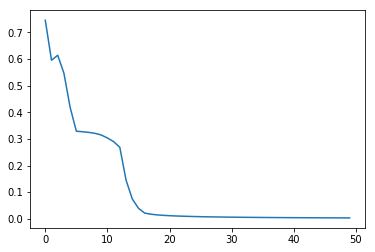

In [6]:
%matplotlib inline

losses = []
epochs = 50
for i_epoch in range(epochs):
#     print('======  EPOCH {}  ======'.format(i_epoch))
    epoch_losses = []
    for k in range(len(X)):
#         print('== Sample {} =========='.format(k))
        v = train_one(X[k], y[k], 0.2)
        epoch_losses.append(0.5*v['e']*v['e'])
        wGreenNeuron += v['update_green']
        wOrangeNeuron += v['update_orange']
        wOutputNeuron += v['update_out']
#         pprint({k:globals()[k] for k in globals() if k.startswith('w')})
    losses.append(np.mean(epoch_losses))
        
from matplotlib import pyplot as plt
plt.plot(list(range(epochs)), losses)